# Classification Main-Pied

## Apprentissage sur stimulation; Test sur imagination

Cerveau Entier - Parcellation BASC (444 régions)

Tous les sujets - SVM Linéaire


In [7]:
import numpy as np

from sklearn.pipeline import Pipeline   
from sklearn.svm import SVC
from sklearn import preprocessing 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
from nilearn.datasets import load_mni152_brain_mask
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from sklearn.cross_validation import LeaveOneLabelOut, cross_val_score, permutation_test_score

%matplotlib inline
import sys
sys.path[0]='Z:/GitHub/gsp-learn/'
from gsplearn.GSPPlot import plot_selectedregions

In [8]:
# Import data
names='ap','as','bh','bi','cmp','cas','cs','cb','gm','gn','gbn','mv','ms','pm','pc','ph','pa','pv','pom','rdc','ti','vs'
smt='ss'
fold_g = 'F:/IRM_Marche/'
label_i=np.loadtxt(fold_g+'label_main.txt','S12')
blocks_i=np.loadtxt(fold_g+'block_main.txt','int')

roi=np.zeros([0,444])
rest=np.zeros([0,444])
label=np.zeros([0,3])
blocks=np.array([])
for n in names:
    sim_filename=fold_g+'mni4060/roi_'+smt+'_'+n+'.npz'
    rest_filename=  fold_g+'mni4060/roirest_'+smt+'_'+n+'.npz'  
    tmproi=np.load(sim_filename)['roi']
    tmprest=np.load(rest_filename)['roi']
    roi=np.concatenate((roi,tmproi))
    rest=np.concatenate((rest,tmprest))
    label=np.append(label,label_i,axis=0)
    blocks=np.append(blocks,blocks_i) 
    
# Remove first volumes per block    
index=[]
for x in range(label.shape[0]):
    if label[x,0]!=label[x-1,0]:
        index.append(x)
    elif label[x,0]!=label[x-2,0]:
        index.append(x)
        
label=np.delete(label,index,0)
blocks=np.delete(blocks,index,0)
roi=np.delete(roi,index,0)

condition_cat = np.logical_or(label[:,1] == b'foot', label[:,1] == b'hand')
condition_out=np.logical_not(label[:,2]== b'des')
condition_mask= condition_cat==condition_out
block=blocks[condition_mask]
y=label[condition_mask]
cond=roi[condition_mask]
   
train_mask= y[:,0]==b'stim'
test_mask= y[:,0]==b'imag'
y_train=y[train_mask,1]
y_test=y[test_mask,1]
roi_train=cond[train_mask]#   
roi_test=cond[test_mask]
block=block[train_mask]

In [9]:
# Classification
scaler = preprocessing.StandardScaler()
svm= SVC(C=1., kernel="linear")  
k=60
feature_selection = SelectKBest(f_classif, k=k)
    
pipeline_anova = Pipeline([('anova', feature_selection), ('scale', scaler),('classif_name', svm)])
pipeline_anova.fit(roi_train, y_train)
prediction = pipeline_anova.predict(roi_test)  
result=accuracy_score(prediction,y_test)
print('Accuracy:',result*100,'%')

Accuracy: 59.9681020734 %


In [10]:
# Prepare ploting
basc = datasets.fetch_atlas_basc_multiscale_2015(version='sym')['scale444']
brainmask = load_mni152_brain_mask()
masker = NiftiLabelsMasker(labels_img = basc, mask_img = brainmask, 
                           memory_level=1, verbose=0,
                           detrend=True, standardize=False,  
                           high_pass=0.01,t_r=2.28,
                           resampling_target='labels'
                           )
masker.fit()

C:\Users\mmenoret\Miniconda2\envs\fmri_3\lib\site-packages\scipy\ndimage\interpolation.py:462: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


NiftiLabelsMasker(background_label=0, detrend=True, high_pass=0.01,
         labels_img='C:\\Users\\mmenoret/nilearn_data\\basc_multiscale_2015\\template_cambridge_basc_multiscale_nii_sym\\template_cambridge_basc_multiscale_sym_scale444.nii.gz',
         low_pass=None,
         mask_img=<nibabel.nifti1.Nifti1Image object at 0x0000000004E00978>,
         memory=Memory(cachedir=None), memory_level=1,
         resampling_target='labels', sessions=None, smoothing_fwhm=None,
         standardize=False, t_r=2.28, verbose=0)

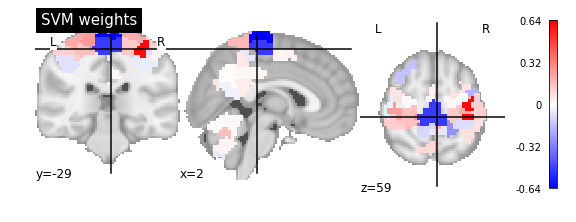

In [11]:
# Plot resulting weights of the SVM & selected regions
weights=pipeline_anova.named_steps['classif_name'].coef_
index=plot_selectedregions(pipeline_anova,masker,weights=weights,anova_name='anova')


### Test du niveau de chance (en gardant la structure de bloc)

In [10]:
### Permutation block
nb_p=1000
null_result=np.zeros(nb_p)

ncond=['hand','foot']
for i in range(nb_p):
    y_train_random=np.zeros((0,1),dtype='S12')
    # shuffle block number
    for suj in range(22):
        xncond=np.random.permutation(ncond)
        suj_train_random=np.append(np.full(57,xncond[0],dtype='S12'),np.full(57,xncond[1],dtype='S12'))
        y_train_random=np.append(y_train_random,suj_train_random)

        
    pipeline_anova.fit(roi_train, y_train_random)
    prediction = pipeline_anova.predict(roi_test) 
    null_result[i]=accuracy_score(prediction,y_test)

sign=(null_result>=result).sum()/nb_p
print(sign)

0.001


Résultats: La classification imagination MAIN/PIED à partir de l'apprentissage de Stimulation MAIN/PIED donne des performances proches de 60 %, et vu le niveau de difficulté (cerveau entier, tache différente entre imagination et stimulation), c'est pas si mal (et largement significatif: p=0.001!)

Concernant les coefficients du SVM obtenus (c'est à dire les régions qui permettent la classification), on retrouve parfaitement les régions motrices de la main et du pied).

### Classification sur Stimulation seulement (de façon cross-validée)

In [15]:
cv = LeaveOneLabelOut(block)
score_cv = cross_val_score(pipeline_anova, roi_train, y_train,cv=cv)
print('STIM only CV',score_cv.mean())

STIM only CV 0.828403078403


## Apprentissage sur imagination; Test sur stimulation

Attention, vu que les taches diffèrent également au niveau visuel, la classification sur cerveau entier risque d'être faite sur le cortex visuel

In [12]:
pipeline_anova.fit(roi_test, y_test)
prediction = pipeline_anova.predict(roi_train)  
print('Accuracy:',accuracy_score(prediction,y_train)*100,'%')

Accuracy: 66.4673046252 %


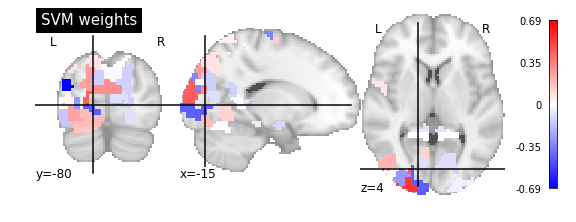

In [13]:
# Plot resulting weights of the SVM & selected regions
weights=pipeline_anova.named_steps['classif_name'].coef_
index=plot_selectedregions(pipeline_anova,masker,weights=weights,anova_name='anova')

Résultats: La classification des données Stimulation MAIN/PIED donne de meilleures performances: 66 %, 
mais quand on regarde les coefficients du SVM obtenus (c'est à dire les régions qui permettent la classification),
on retrouve seulement les régions visuelles, donc probablement dues a des différences autres que motrices.
Etant donné la différence dans le conditions de l'input visuel, il est impossible d'interpreter ces poids.

## Analyse par sujets: 
Ne donne pas de bons résultats (classification significativement meilleure que la chance seulement chez 3 sujets.

## Apprentissage Stimulation sur tous les sujets - Test sur imagination par sujet

In [18]:
pipeline_anova.fit(roi_train, y_train_random)
index_i=[]
for x in range(label_i.shape[0]):
    if label_i[x,0]!=label_i[x-1,0]:
        index_i.append(x)
    elif label_i[x,0]!=label_i[x-2,0]:
        index_i.append(x)
        
label_i=np.delete(label_i,index_i,0)
blocks_i=np.delete(blocks_i,index_i,0)

condition_cat_i = np.logical_or(label_i[:,1] == b'foot', label_i[:,1] == b'hand')
condition_out_i=np.logical_not(label_i[:,2]== b'des')
condition_mask_i= condition_cat_i==condition_out_i
block_i=blocks_i[condition_mask_i]
y_i=label_i[condition_mask_i]

   
#train_mask_i= y_i[:,0]==b'stim'
test_mask_i= y_i[:,0]==b'imag'
#y_train_i=y_i[train_mask_i,1]
y_test_i=y_i[test_mask_i,1]
  
block_i=block_i[test_mask_i]
for n in names:
    sim_filename=fold_g+'mni4060/roi_'+smt+'_'+n+'.npz'
    roi_i=np.load(sim_filename)['roi']
    roi_i=np.delete(roi_i,index_i,0)
    cond_i=roi_i[condition_mask_i]
    roi_test_i=cond_i[test_mask_i]
    #roi_train_i=cond_i[train_mask_i]# 
    prediction = pipeline_anova.predict(roi_test_i)  
    print(n,'Accuracy:',accuracy_score(prediction,y_test_i)*100,'%')
    

C:\Users\mmenoret\Miniconda2\envs\fmri_3\lib\site-packages\ipykernel_launcher.py:29: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 570 but corresponding boolean dimension is 210


ap Accuracy: 61.9047619048 %
as Accuracy: 45.2380952381 %
bh Accuracy: 59.5238095238 %
bi Accuracy: 45.2380952381 %
cmp Accuracy: 54.7619047619 %
cas Accuracy: 52.380952381 %
cs Accuracy: 40.4761904762 %
cb Accuracy: 61.9047619048 %
gm Accuracy: 30.9523809524 %
gn Accuracy: 30.9523809524 %
gbn Accuracy: 47.619047619 %
mv Accuracy: 42.8571428571 %
ms Accuracy: 66.6666666667 %
pm Accuracy: 54.7619047619 %
pc Accuracy: 50.0 %
ph Accuracy: 50.0 %
pa Accuracy: 57.1428571429 %
pv Accuracy: 50.0 %
pom Accuracy: 57.1428571429 %
rdc Accuracy: 57.1428571429 %
ti Accuracy: 50.0 %
vs Accuracy: 52.380952381 %


Apprentissage Stim Hand/Foot sur tous les sujets, et test individuel Imag Hand/Foot ne marche pas non plus 